In [ ]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
remotes::install_github("satijalab/seurat", ref = "release/4.0.0")

R[write to console]: Skipping install of 'Seurat' from a github remote, the SHA1 (da578a42) has not changed since last install.
  Use `force = TRUE` to force installation



In [ ]:
%%R
devtools::install_github('satijalab/seurat-data')

R[write to console]: Skipping install of 'SeuratData' from a github remote, the SHA1 (c633765b) has not changed since last install.
  Use `force = TRUE` to force installation



In [ ]:
%%R
library(Seurat)
library(SeuratData)
library(cowplot)
library(dplyr)
InstallData("bmcite")
bm <- LoadData(ds = "bmcite")
bm_pred <- LoadData(ds = "bmcite")

In [ ]:
%%R
DefaultAssay(bm) <- 'RNA'
bm <- NormalizeData(bm) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(reduction.name = 'rpca')
DefaultAssay(bm) <- 'ADT' 
VariableFeatures(bm) <- rownames(bm[["ADT"]])
bm <- NormalizeData(bm, normalization.method = 'CLR', margin = 2) %>% 
  ScaleData() %>% RunPCA(reduction.name = 'apca')


In [ ]:
%%R
DefaultAssay(bm_pred) <- 'RNA'
bm_pred <- NormalizeData(bm_pred) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(reduction.name = 'rpca')
DefaultAssay(bm_pred) <- 'ADT'
VariableFeatures(bm_pred) <- rownames(bm_pred[["ADT"]])

bm_pred <- NormalizeData(bm_pred, normalization.method = 'CLR', margin = 2) 
bm_p.pADT <- read.csv("/content/drive/MyDrive/Curriculars/AACB_course_project/Datasets/ADT_XGBoost_prediction.csv", header = TRUE, row.names = 1)
colnames(bm_p.pADT) <- colnames(GetAssayData(bm_pred, slot = 'data'))
bm_p.pADT <- as.matrix(bm_p.pADT)
DefaultAssay(bm_pred) <- 'ADT'
bm_pred <- SetAssayData(bm_pred, slot = "data", new.data = bm_p.pADT)
bm_pred <- ScaleData(bm_pred) %>% RunPCA(reduction.name = 'papca')


In [ ]:
%%R
# Identify multimodal neighbors. These will be stored in the neighbors slot, 
# and can be accessed using bm[['weighted.nn']]
# The WNN graph can be accessed at bm[["wknn"]], 
# and the SNN graph used for clustering at bm[["wsnn"]]
# Cell-specific modality weights can be accessed at bm$RNA.weight
bm <- FindMultiModalNeighbors(
  bm, reduction.list = list("rpca", "apca"), 
  dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
)

bm_pred <- FindMultiModalNeighbors(
  bm_pred, reduction.list = list("rpca", "papca"), 
  dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
)

In [ ]:
%%R
bm <- RunUMAP(bm, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
bm <- FindClusters(bm, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

bm_pred <- RunUMAP(bm_pred, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
bm_pred <- FindClusters(bm_pred, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

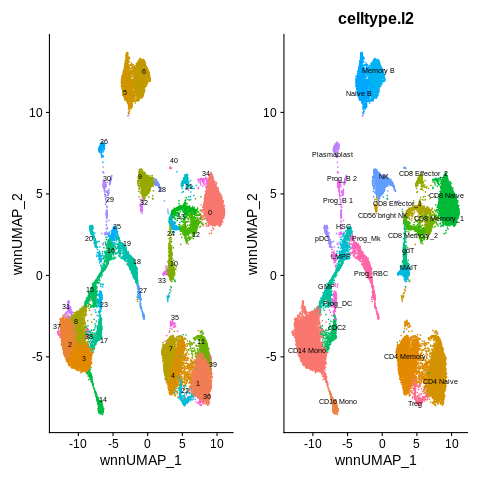

In [ ]:
%%R
p1 <- DimPlot(bm, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(bm, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1+p2

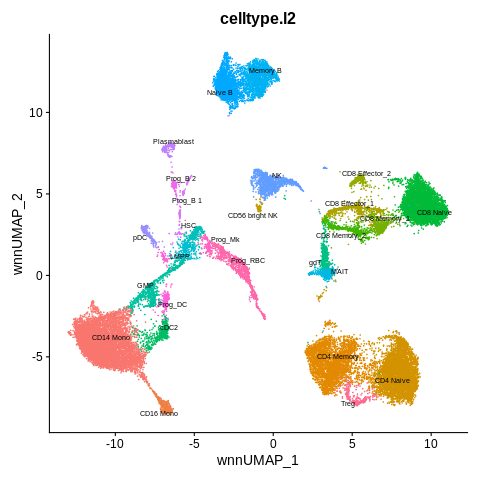

In [ ]:
%%R
p2

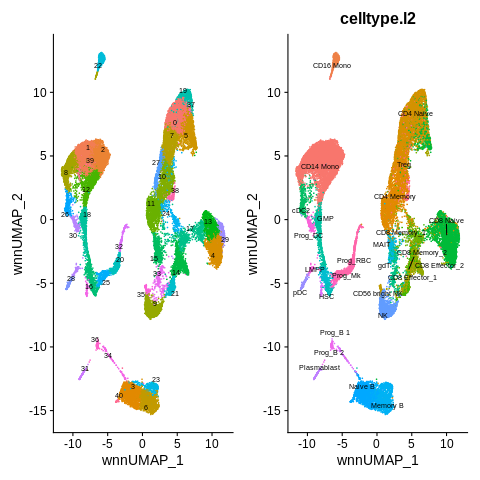

In [ ]:
%%R
p1 <- DimPlot(bm_pred, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(bm_pred, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

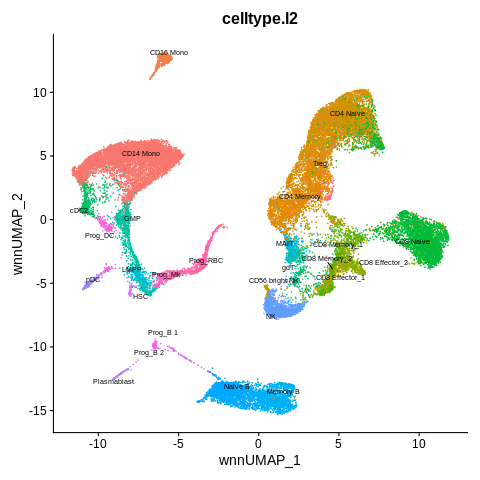

In [ ]:
%%R
p2

In [ ]:
%%R
bm <- RunUMAP(bm, reduction = 'rpca', dims = 1:30, assay = 'RNA', 
              reduction.name = 'rna.umap', reduction.key = 'rnaUMAP_')
bm <- RunUMAP(bm, reduction = 'apca', dims = 1:18, assay = 'ADT', 
              reduction.name = 'adt.umap', reduction.key = 'adtUMAP_')

bm_pred <- RunUMAP(bm_pred, reduction = 'rpca', dims = 1:30, assay = 'RNA', 
              reduction.name = 'rna.umap', reduction.key = 'rnaUMAP_')
bm_pred <- RunUMAP(bm_pred, reduction = 'papca', dims = 1:18, assay = 'ADT', 
              reduction.name = 'adt.umap', reduction.key = 'adtUMAP_')

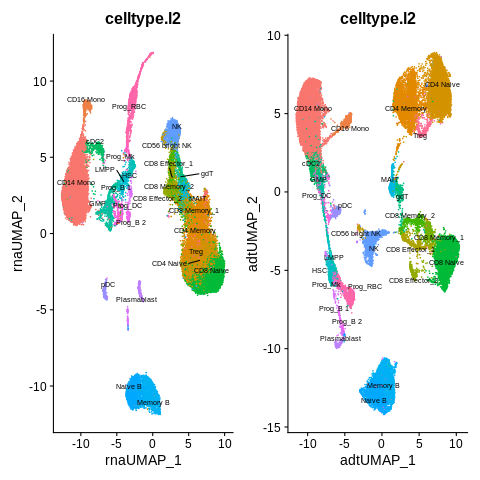

In [ ]:
%%R
p3 <- DimPlot(bm, reduction = 'rna.umap', group.by = 'celltype.l2', label = TRUE, 
              repel = TRUE, label.size = 2.5) + NoLegend()
p4 <- DimPlot(bm, reduction = 'adt.umap', group.by = 'celltype.l2', label = TRUE, 
              repel = TRUE, label.size = 2.5) + NoLegend()
p3 + p4

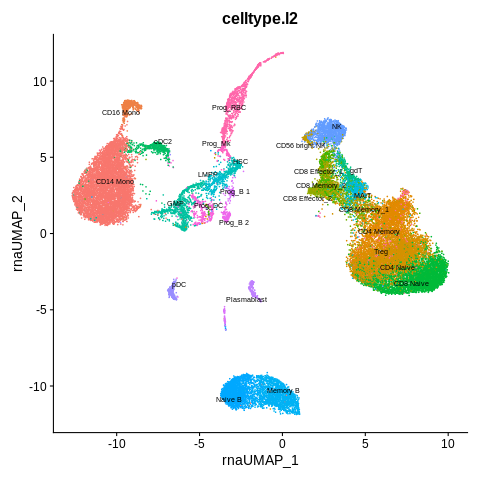

In [ ]:
%%R
p3

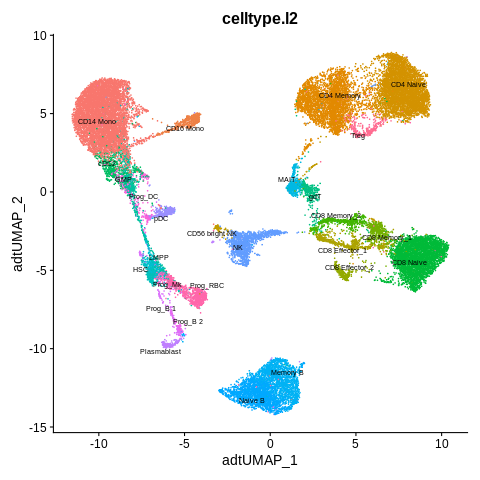

In [ ]:
%%R
p4

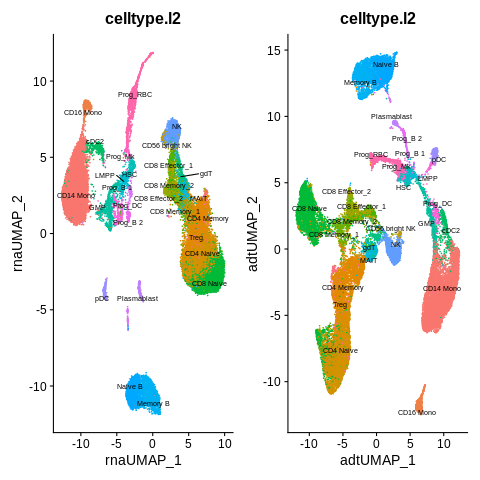

In [ ]:
%%R
p3 <- DimPlot(bm_pred, reduction = 'rna.umap', group.by = 'celltype.l2', label = TRUE, 
              repel = TRUE, label.size = 2.5) + NoLegend()
p4 <- DimPlot(bm_pred, reduction = 'adt.umap', group.by = 'celltype.l2', label = TRUE, 
              repel = TRUE, label.size = 2.5) + NoLegend()
p3 + p4

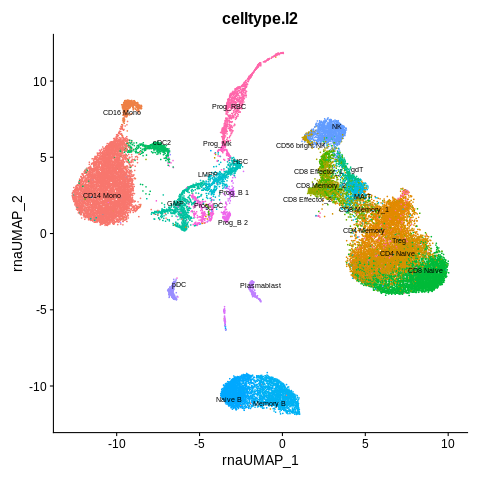

In [ ]:
%%R
p3

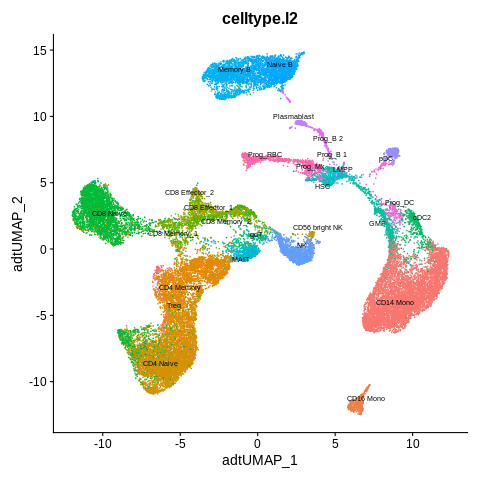

In [ ]:
%%R
p4

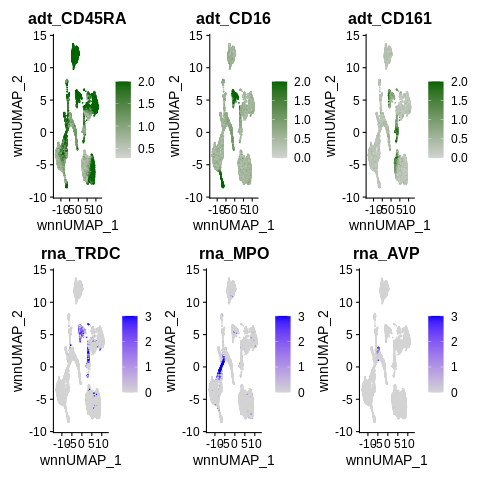

In [ ]:
%%R
p5 <- FeaturePlot(bm, features = c("adt_CD45RA","adt_CD16","adt_CD161"),
                  reduction = 'wnn.umap', max.cutoff = 2, 
                  cols = c("lightgrey","darkgreen"), ncol = 3)
p6 <- FeaturePlot(bm, features = c("rna_TRDC","rna_MPO","rna_AVP"), 
                  reduction = 'wnn.umap', max.cutoff = 3, ncol = 3)
p5 / p6

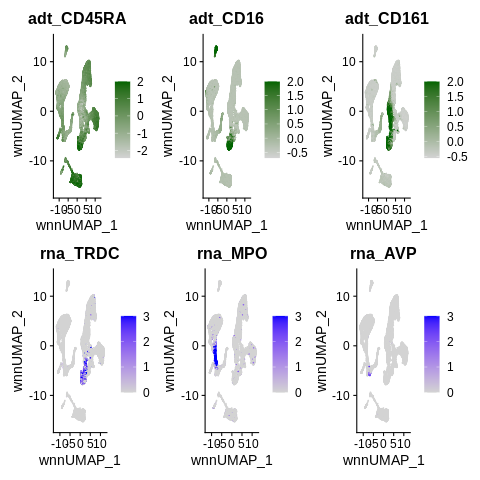

In [ ]:
%%R
p5 <- FeaturePlot(bm_pred, features = c("adt_CD45RA","adt_CD16","adt_CD161"),
                  reduction = 'wnn.umap', max.cutoff = 2, 
                  cols = c("lightgrey","darkgreen"), ncol = 3)
p6 <- FeaturePlot(bm_pred, features = c("rna_TRDC","rna_MPO","rna_AVP"), 
                  reduction = 'wnn.umap', max.cutoff = 3, ncol = 3)
p5 / p6

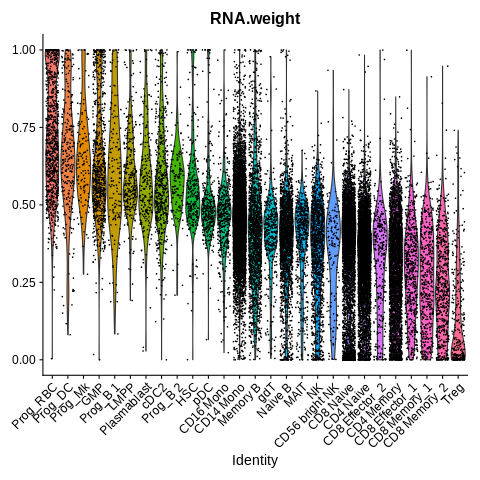

In [ ]:
 %%R
 VlnPlot(bm, features = "RNA.weight", group.by = 'celltype.l2', sort = TRUE, pt.size = 0.1) +
  NoLegend()

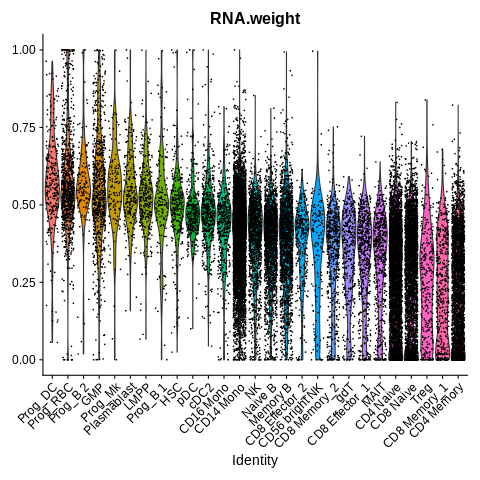

In [ ]:
 %%R
 VlnPlot(bm_pred, features = "RNA.weight", group.by = 'celltype.l2', sort = TRUE, pt.size = 0.1) +
  NoLegend()